## Noise / Data separation in segmented 3 D volumes

In [16]:
import numpy as np
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt
from algo.stats import cohen_d
from collections import defaultdict
import seaborn as sns
from tools.tools import treedir
import os
from scipy import stats
# from tools.plotter import density, iqr_plot
outpath = '/home/bcardoen/SFUVault/Repositories/smlm-double-labelling-analysis/images/rory'
datapath = '/home/bcardoen/SFUVault/Repositories/smlm-double-labelling-analysis/data/rory'

In [22]:
def density(values, title, outpath, labels, Xlabel, rug=False, ylim=None, ylabel=None, kde=False):
    f, ax = plt.subplots(1)
    assert(len(values) == len(labels))
    for v, l in zip(values, labels):
        s = sns.distplot(v, hist=True, kde=kde, rug=rug, label=l, ax=ax).set_xlabel(Xlabel);
    if ylim:
        ax.set_ylim([0, ylim])
    f.set_size_inches(11.7, 8.27)
    if ylabel:
        ax.set_ylabel(ylabel)
    sns.set(font_scale=1.5)
    f.suptitle(title)
    fname = title.replace(' ', '_') + '.png'
    plt.legend()
    f.savefig(os.path.join(outpath, fname))
    
def getfeature(data, featureindex, channel, treatment):
    return data[channel][treatment][1][:,featureindex]

def iqr_plot(values, title, outpath, labels, ylabel=None, colors=None, markmedian=False, log=True):
    f, ax = plt.subplots(1)
    if log:
        ax.set_yscale("log", nonposy='clip')
    ax = sns.boxplot(data=values, ax = ax)
    if ylabel:
        ax.set_ylabel(ylabel)
    if labels:
        ax.set_xticklabels(labels)
    if colors:
        boxes = ax.artists
        for box, color in zip(boxes, colors):
            box.set_facecolor(color)
    if markmedian:
        medians = [np.median(value) for value in values]
        median_labels = [str(np.round(s, 2)) for s in medians]

        pos = range(len(medians))
        for tick, label in zip(pos, ax.get_xticklabels()):
            ax.text(pos[tick], medians[tick] + 0.5, median_labels[tick],
                horizontalalignment='center', size='x-small', color='w', weight='semibold')
    f.set_size_inches(11.7, 8.27)
    sns.set(font_scale=1.5)
    f.suptitle(title)
    fname = title.replace(' ', '_') + '.png'
    f.savefig(os.path.join(outpath, fname))
    
def treedir(pathname):
    (t, d, f)  = next(os.walk(pathname))
    return {**{dir:treedir(os.path.join(pathname, dir)) for dir in d}, **{file:os.path.join(t, file) for file in f}}



### Load data

In [18]:
tree = treedir(datapath)
csvs = [ (fn, fp) for (fn, fp) in tree.items() if fn.endswith('.csv')]
data = defaultdict(dict)
featurenames = []
feature_axis = {1:'nm^2', 2:'nm^3'}
for (csv, csvp) in csvs:
    keys = csv.replace('.csv', '').split('_')
    with open(csvp) as f:
        ct = f.readlines()
        header = ct[0].rstrip()
        features = header.split(',')
        featurenames = features if len(features) > len(featurenames) else featurenames
        data[keys[0]][keys[1]] = (features, np.loadtxt(ct[1:], delimiter = ','))

channels = list(data.keys())
treatments = list(data[channels[0]].keys())
print('Read the following treatments {}'.format(treatments))
print('Read the following features {}'.format(featurenames))

Read the following treatments ['infected', 'noninfected']
Read the following features ['Id', 'Surface Area: Surface Area', 'Volume: Volume', 'Intensities (Ch 5): Min', 'Intensities (Ch 5): Max', 'Intensities (Ch 5): Mean', 'Intensities (Ch 5): Sum', 'Intensities (Ch 5): SD', 'Intensities (Ch 5): SNR (Mean/SD)']


## Compute statistics
* P values : if p < a --> change in mean is explained by experiment rather than variability in sampling
* Effect size: D (ratio in standard deviation), by how much do the means shift?
* Power of statistic : What is the probability that, if there is an effect, we accurately report it as such ? (P>0.8)

In [23]:
a = 0.05
Ps = defaultdict(dict)
# Select Area, Volume (1,2)
featureindices = [1,2] 
for featureindex in featureindices:
    for channel, channel_data in data.items():        
        assert(len(treatments) == 2)
        treated, nontreated = [ getfeature(data, featureindex, channel, treatment) for treatment in treatments]
        nobs1 = treated.shape[0]
        nobs2 = nontreated.shape[0]
        ratio = nobs2/nobs1
        _, p = stats.ttest_ind(nontreated, treated, equal_var = False)
        d, sd = cohen_d(nontreated, treated)
        assert(nobs2 == nobs1*ratio)
        P = TTestIndPower().solve_power(power=None, nobs1=nobs1, ratio=ratio, alpha=a, effect_size=abs(d))
        if P >= 0.8 and p<a:
            print('Significant change in mean with high statistical power.')
        print('P value {0:1.2e} Effect Size {0:1.2e} SD {0:1.2e} Power {0:1.2e}'.format(p, d, sd, P))
        Ps[featureindex][channel] = p, d, sd, P 

Significant change in mean with high statistical power.
P value 5.01e-35 Effect Size 5.01e-35 SD 5.01e-35 Power 5.01e-35
Significant change in mean with high statistical power.
P value 6.07e-89 Effect Size 6.07e-89 SD 6.07e-89 Power 6.07e-89
Significant change in mean with high statistical power.
P value 6.24e-90 Effect Size 6.24e-90 SD 6.24e-90 Power 6.24e-90
Significant change in mean with high statistical power.
P value 4.93e-72 Effect Size 4.93e-72 SD 4.93e-72 Power 4.93e-72


### Plot distributions for each channel, comparing treatments per feature.

/home/bcardoen/miniconda3/envs/smlm/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


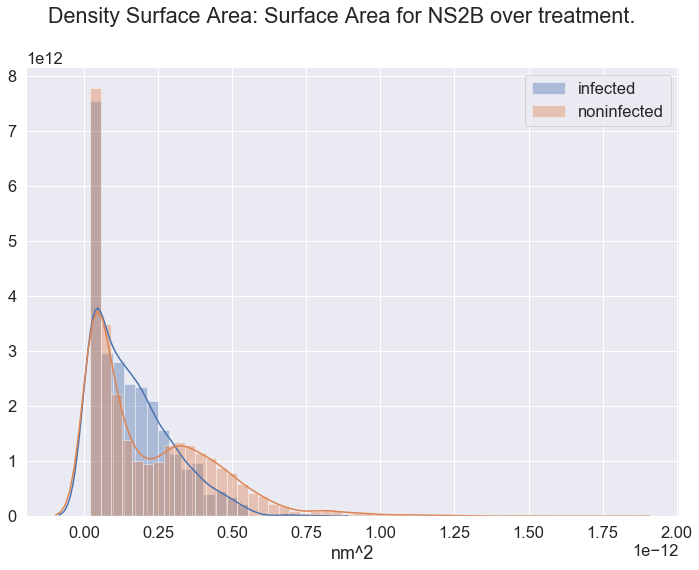

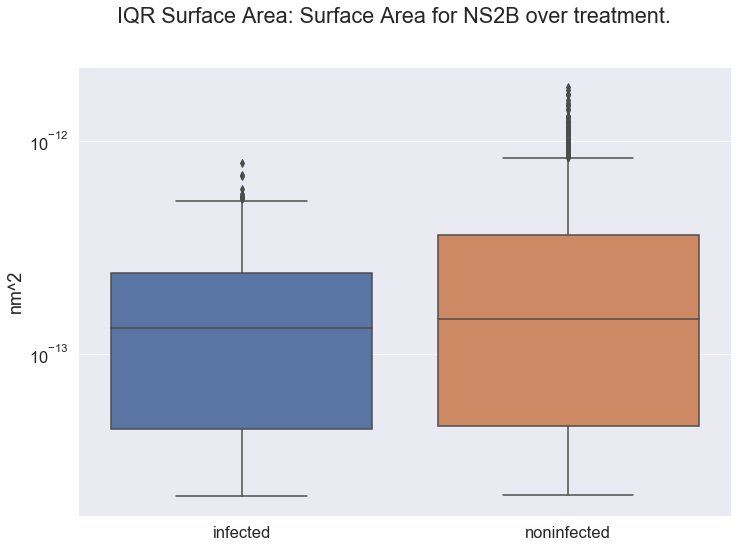

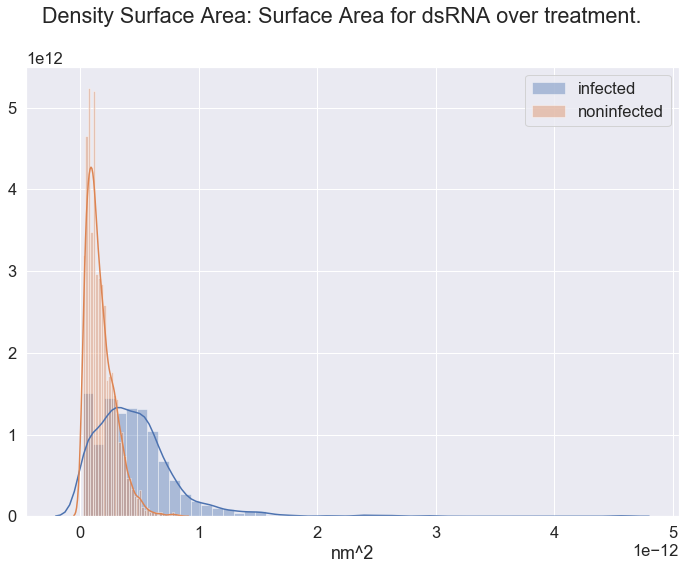

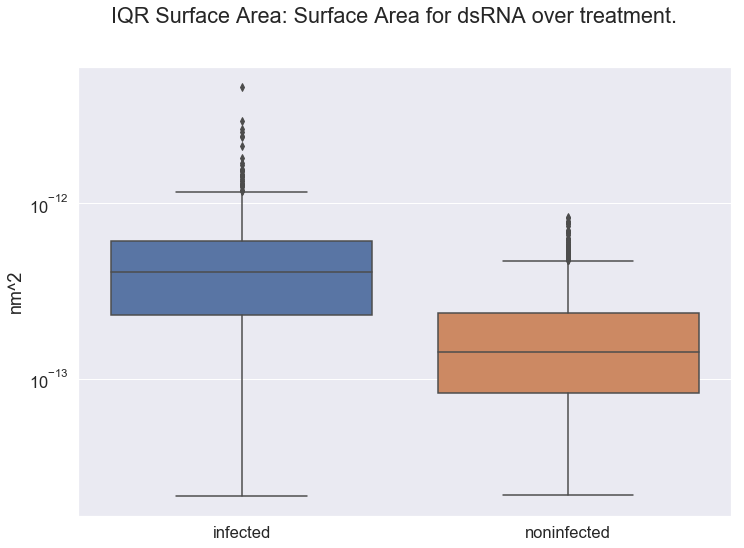

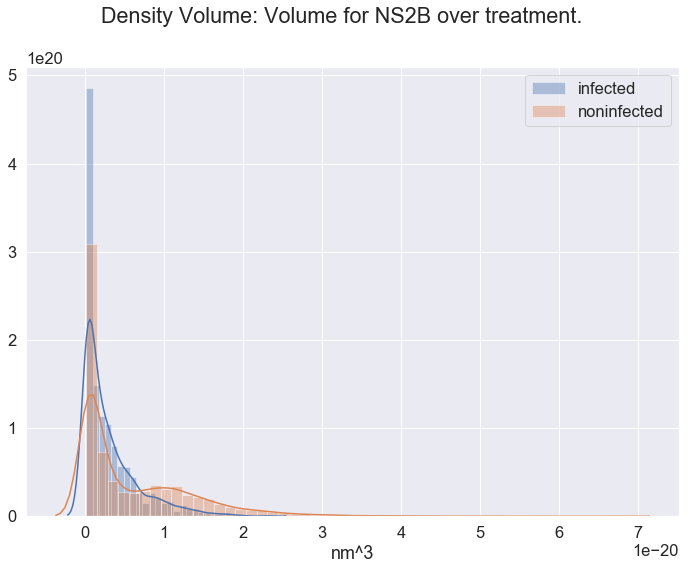

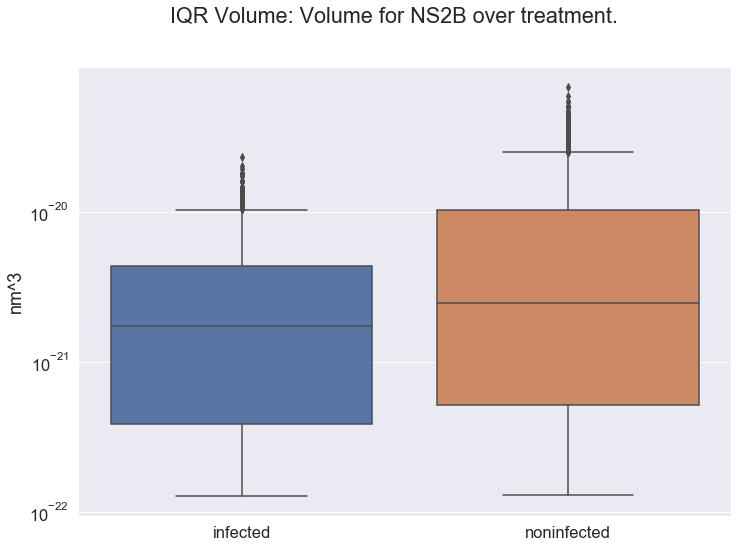

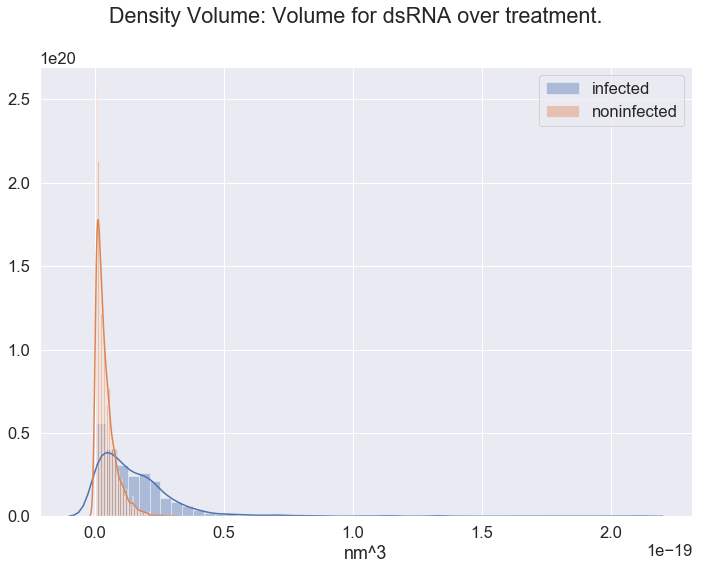

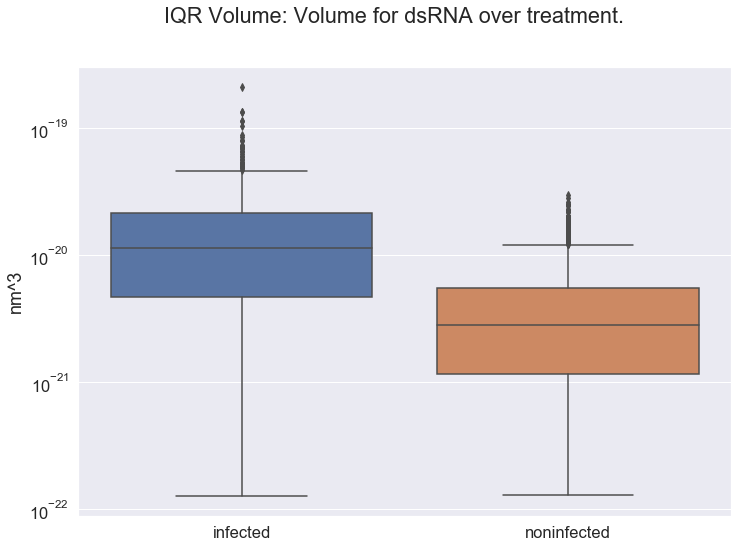

In [24]:
featureindices = [1,2]
for featureindex in featureindices:
    for channel in channels:
        featured = [getfeature(data, featureindex, channel, treatment) for treatment in treatments]
        title = 'Density {} for {} over treatment.'.format(featurenames[featureindex], channel)
        density(featured, title, outpath, treatments, Xlabel=feature_axis[featureindex] , kde=True)
        title = 'IQR {} for {} over treatment.'.format(featurenames[featureindex], channel)
        iqr_plot(featured, title, outpath, treatments, ylabel=feature_axis[featureindex])
#         def iqr_plot(values, title, outpath, labels, ylabel=None, colors=None, markmedian=False):
